In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv('../data/imbd _dataset.csv')

In [33]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [34]:
# Remove html tags in review column with regex
df = df.replace(to_replace ='<[^>]*>', value = '', regex = True)

In [35]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [36]:
df.shape

(50000, 2)

In [37]:
X_train, X_test = df[:49900], df[49900:]
X_test

,review,sentiment
49900,"I had few problems with this film, and I have ...",positive
49901,This program is a lot of fun and the title son...,positive
49902,Greenaway seems to have a habit of trying deli...,negative
49903,This is one of the most hateful and cruel movi...,negative
49904,"""Air Bud 2: Golden Receiver"" is a very bad reh...",negative
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [39]:
# Convert seentiment to numeric. In this case, 0 for positive and 1 for negative
sentiment_label = df.sentiment.factorize()
sentiment_label

(array([0, 0, 0, ..., 1, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

In [40]:
# Assign a number to each word and replace with that number in the sentence

# Get the actual texts from the data frame
review = df.review.values
# Initialize the tokenizer with a 5000 word limit. This is the number of words we would like to encode
tokenizer = Tokenizer(num_words=5000)
# Call fit_on_texts to create associations of words and numbers as shown in the image below.
tokenizer.fit_on_texts(review)

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)
# As the model input requires to have equal length, the sequence is padded to have a length
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [41]:
# Review and the corresponding numeric representation of it
print(review[0][:200])
print(padded_sequence[0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was it
[  37  569   92    6 3800    7    1  359  355    4    1  661    8    6
  432 3182   13   11    6    1  357    5    1 2560 1062    8 2708 1420
   19  538   31 4659 2467    4    1 1207  116   28    1   24 2975    2
  390   33    6   20  297   19    1 4936  538    6  343    5  105 2451
    2   50   33  326    2   22  109  224  242    9   57  130    1  279
 1322    4    1  118    6  692    5    1  191   11    8  268  116   78
  275  588 3026  833  179 1319 4158   14 2520 1240  833 1442  833  886
 3182  148  953  182    1   85  397    9  122  209 3237   67   13   33
 1635    8   12 2242    9  412  130    9   12 1591   14    8   17   13
    9  286   50    9 1415    3 1279   14 3182    2  188    5    1  297
 2042    4 2149  569   20   38  569   17   25 2981   41   14    3  503
   19  641    2   

In [43]:
# Build the model

embedding_vector_length = 32

model = Sequential()

model.add(Embedding(vocab_size, embedding_vector_length, input_length=len(padded_sequence[0])))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           4048192   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 4,064,843
Trainable params: 4,064,843
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
history = model.fit(padded_sequence,sentiment_label[0],
                  validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
1250/1250 [==============================] - 148s 117ms/step - loss: 0.5108 - accuracy: 0.7269 - val_loss: 0.3331 - val_accuracy: 0.8636
Epoch 2/5
1250/1250 [==============================] - 141s 113ms/step - loss: 0.2954 - accuracy: 0.8805 - val_loss: 0.2875 - val_accuracy: 0.8812
Epoch 3/5
1250/1250 [==============================] - 141s 113ms/step - loss: 0.2686 - accuracy: 0.8918 - val_loss: 0.3011 - val_accuracy: 0.8811
Epoch 4/5
1250/1250 [==============================] - 124s 100ms/step - loss: 0.2461 - accuracy: 0.9023 - val_loss: 0.2812 - val_accuracy: 0.8865
Epoch 5/5
1250/1250 [==============================] - 131s 105ms/step - loss: 0.2321 - accuracy: 0.9077 - val_loss: 0.3249 - val_accuracy: 0.8779


In [45]:
def analyze_sentence(sentence):
    tw = tokenizer.texts_to_sequences([sentence])
    tw = pad_sequences(tw, maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print(model.predict(tw))
    return sentiment_label[1][prediction]

In [46]:
print(analyze_sentence("I saw this when it first came out and was shocked even then by the complete failure of the Hollywood hacks who made the film to either put Conan on the screen or even just make a decent movie. Phew. Recently, I tried to watch it again, twenty-odd years later - and I gagged. It's irredeemable. It's on a par with Plan 9. Only it's more boring."))

[[0.9309393]]
negative


In [47]:
model.save('./imdb_sentiment_analyzer')

INFO:tensorflow:Assets written to: ./imdb_sentiment_analyzer/assets


In [48]:
def analyze_sentence2(sentence:str, sentiment_score:int, serie):
    if sentiment_score == -1:
        sentiment_score = 0
    serie[0].append(sentiment_score)
    
    tw = tokenizer.texts_to_sequences([sentence])
    tw = pad_sequences(tw, maxlen=200)
    pred = model.predict(tw)
    prediction = int(pred.round().item())
    serie[1].append(pred[0])
    return sentiment_label[1][prediction]

series = [[],[]]
for text, sentiment in X_test.values[:100]:
    analyze_sentence2(text, sentiment, series)


Text(0.5, 1.0, 'Test Dataset')

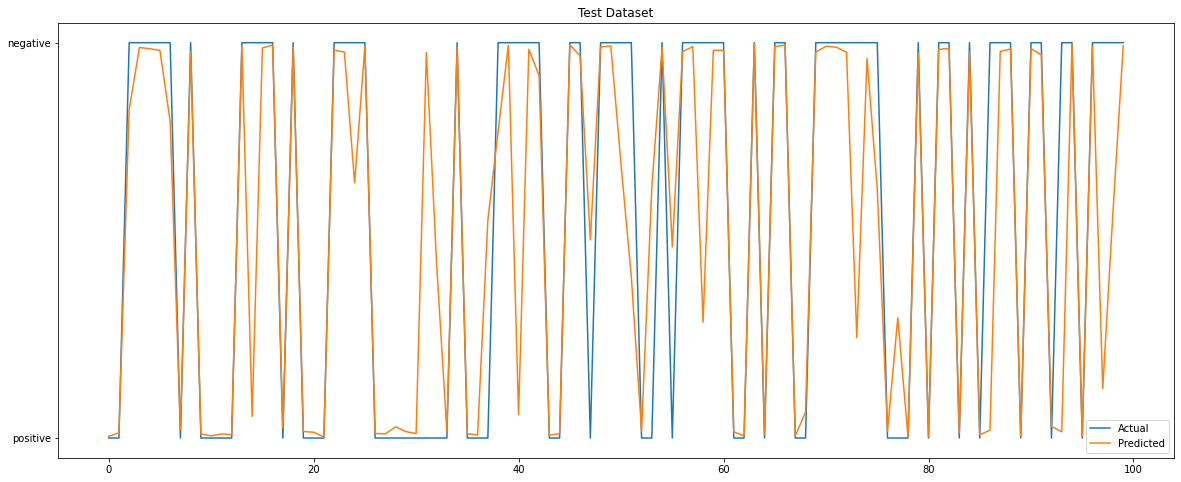

In [49]:
plt.figure(figsize=(20,8))

#Xt = model.predict(X_test)
#ax=[[series[0], series[1]]].plot()

plt.plot(series[0], label="Actual")
plt.plot(series[1], label="Predicted")
plt.legend()
plt.title("Test Dataset")